# Vegetation detection

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import sys
sys.path.append("../common/")

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from data_utils import TRAIN_IMAGE_IDS, LABELS
from image_utils import get_image_data, TRAIN_DATA, TRAIN_LABEL_TILES, get_image_tile_data, compute_mean_std_on_images
from visu_utils import display_img_1b, display_labels

In [4]:
import cv2
import numpy as np
np.random.seed(2017)

### Input data

Images of shape (512, 512, 17) 

In [5]:
from unet import unet_one_test, unet_zero, unet_two, unet_one, unet_ratios, unet_three

Using Theano backend.


Keras user configuration is setup


In [6]:
for i, l in enumerate(LABELS):
    print i, l

0 None
1 Buildings
2 Misc. Manmade structures
3 Road
4 Track
5 Trees
6 Crops
7 Waterway
8 Standing water
9 Vehicle Large
10 Vehicle Small


In [7]:
# RESIZE_TILES = False
# # tile_size = (512, 512)
# tile_size = (128, 128)
# n_channels = 17
# model = unet_zero(len(LABELS)-1, n_channels, *tile_size)

In [8]:
from glob import glob
all_train_files = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_files = np.array([s[len(TRAIN_DATA)+1:-4] for s in all_train_files])
print "First train tile : ", all_train_files[0]

First train tile :  6010_1_2


In [11]:
ll = int(len(all_train_files)*0.7)
train_files = all_train_files[:ll]
val_files = all_train_files[ll:]

mean_fname = os.path.join(TRAIN_DATA, 'mean_image.npz')
std_fname = os.path.join(TRAIN_DATA, 'std_image.npz')
if not os.path.exists(mean_fname) or not os.path.exists(std_fname):
    logging.getLogger().setLevel(logging.INFO)
    mean_image, std_image = compute_mean_std_on_images(train_files)
    logging.getLogger().setLevel(logging.WARN)
    np.savez(mean_fname, mean_image)
    np.savez(std_fname, std_image)
else:
    mean_image = np.load(mean_fname)['arr_0']
    std_image = np.load(std_fname)['arr_0']

print mean_image.shape, std_image.shape
print mean_image.min(), mean_image.max(), std_image.min(), std_image.max()
len(train_files), len(val_files)

(3349, 3404, 17) (3349, 3404, 17)
0.0 5261.28 0.0 3649.91095037


(17, 8)

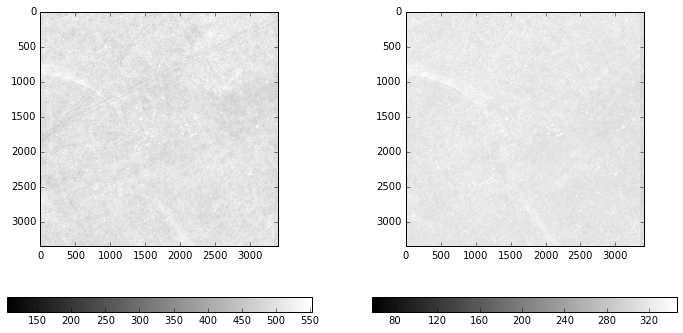

In [12]:
plt.figure(figsize=(12,6))
plt.subplot(121)
display_img_1b(mean_image[:,:,0])
plt.subplot(122)
display_img_1b(mean_image[:,:,1])

In [14]:
from data_utils import get_image_ids
from training_utils import tile_iterator

In [15]:
from data_utils import get_image_ids
from training_utils import tile_iterator


def normalize_image(img_data, mean_image=None, std_image=None):
    out = img_data.astype(np.float32)    
    if mean_image is not None or std_image is not None:
        out -= mean_image 
        out /= std_image
    out = out.transpose([2,0,1])
    return out


def generate_images(image_ids_to_use, batch_size):
    while True:        
        X = np.zeros((batch_size, n_channels)+tile_size, dtype=np.float32)
        Y = np.zeros((batch_size, n_labels)+tile_size, dtype=np.float32)
        tiles = tile_iterator(image_ids_to_use, labels, 
                              presence_percentage=2, 
                              tile_size=tile_size, 
                              mean_image=mean_image,
                              std_image=std_image)
        counter = 0
        for x, y in tiles:                
            if n_channels < 17:
                x = x[:,:,channels]
            
            x = normalize_image(x)
            y = normalize_image(y)     

            X[counter,:,:,:] = x
            Y[counter,:,:,:] = y 
            counter += 1
            if counter == batch_size:
                yield (X, Y)
                counter = 0

Training class groups : number of pixels x appearence frequency ~ probability that a pixel of the image is of a class

1. `Buildings` and `Misc. Manmade structures` and `Track` : [1, 2, 4]
2. `Standing water` and `Road` and `Waterway` : [8, 3, 7]
3. `Trees` and `Crops`: [5, 6]
4. `Vehicle Small` : [10]
5. `Vehicle Large` : [9]


In [19]:
tile_size = (256, 256)
channels = np.array(range(17))
# channels = np.array([0, 1, 2, 3, 4])
n_channels = len(channels)

# labels = np.array(range(len(LABELS)))
labels = np.array([1, 2, 4])
n_labels = len(labels)

In [20]:
# batch_size = 64
# for X, Y in generate_images(train_files, batch_size):
#     print X.shape, Y.shape
#     print X.min(), X.mean(), X.max(), Y.min(), Y.max()
#     break

(64, 17, 256, 256) (64, 3, 256, 256)
-3.62004 0.246657 4.89898 0.0 1.0


(5, 17, 256, 256) (5, 3, 256, 256)
-3.13483 4.40915 0.0 1.0


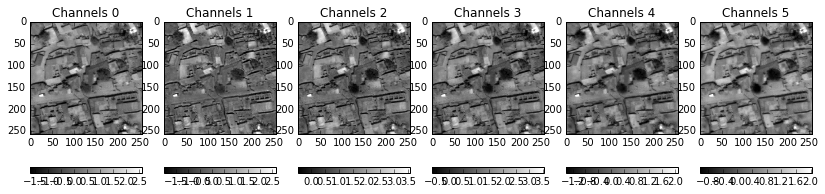

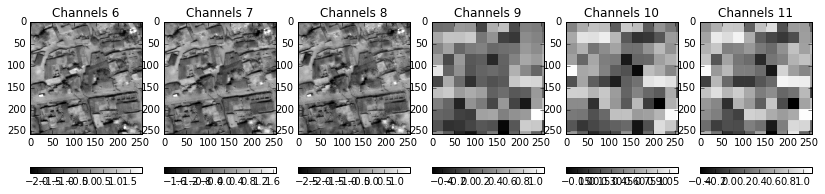

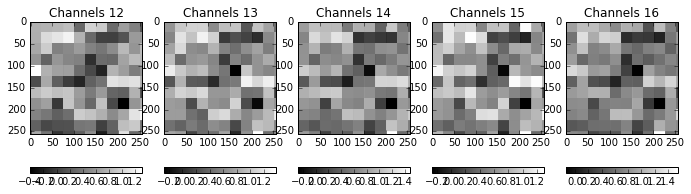

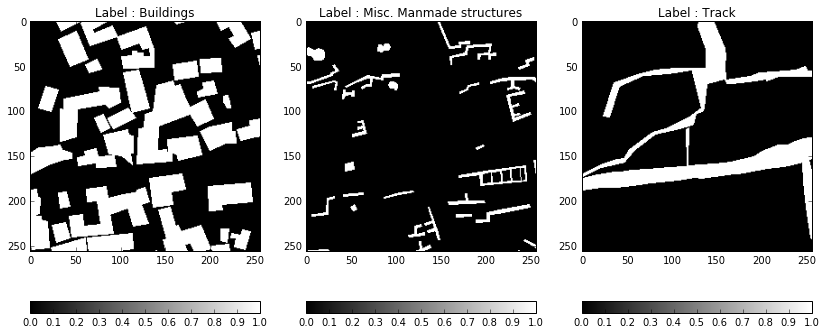

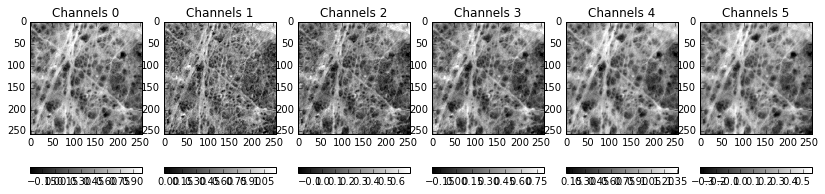

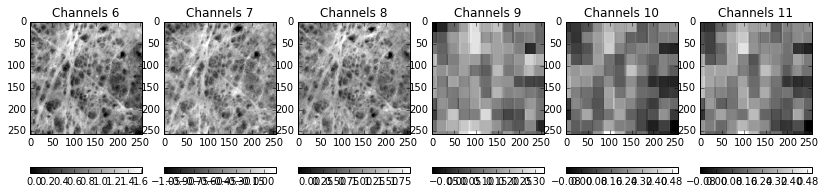

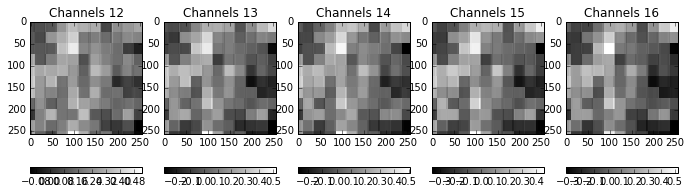

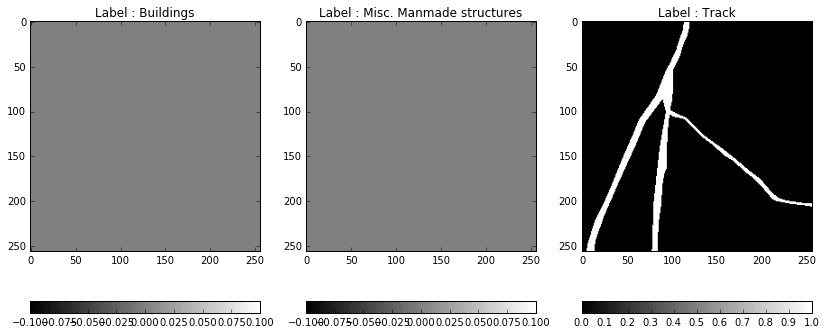

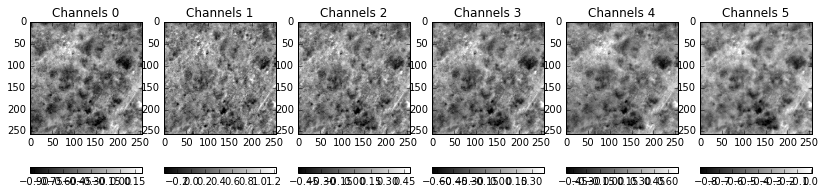

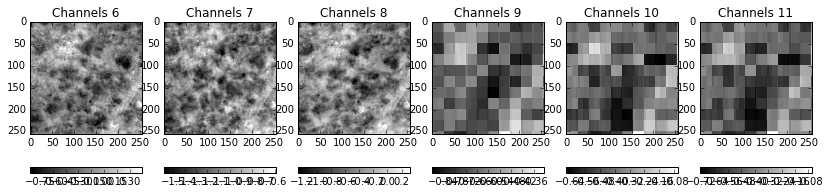

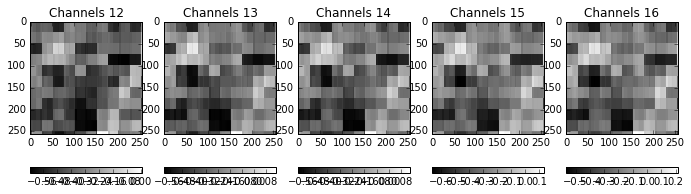

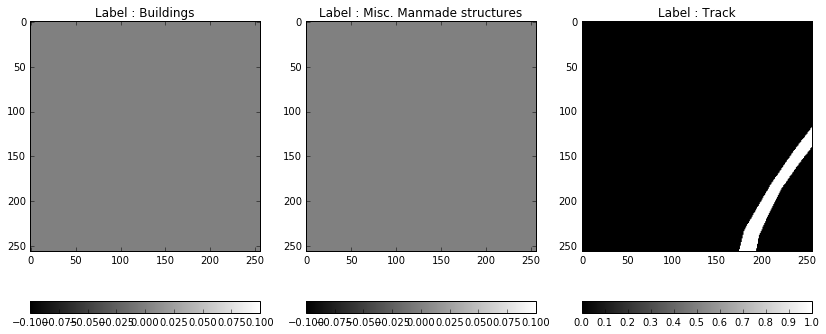

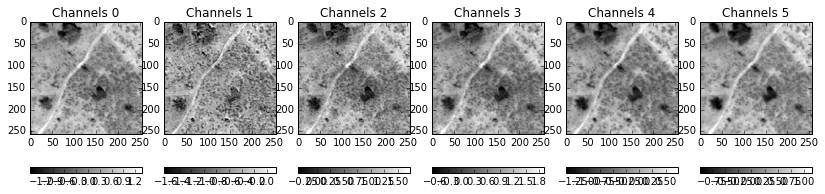

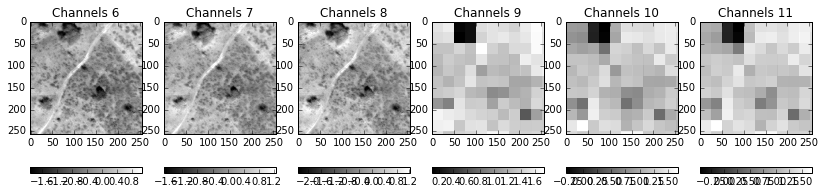

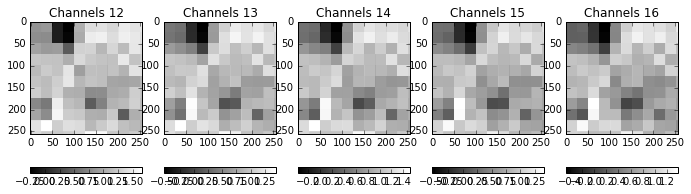

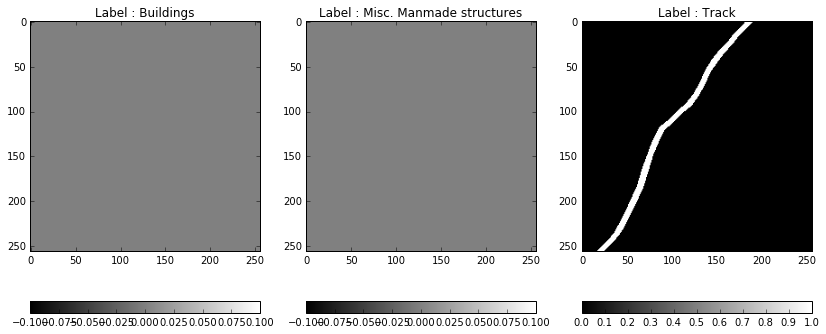

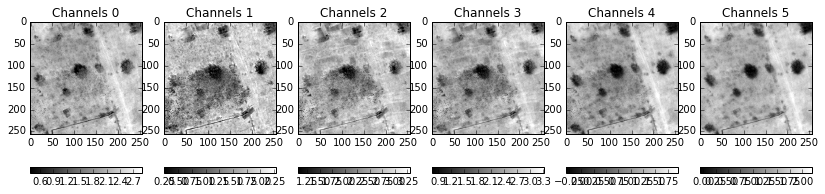

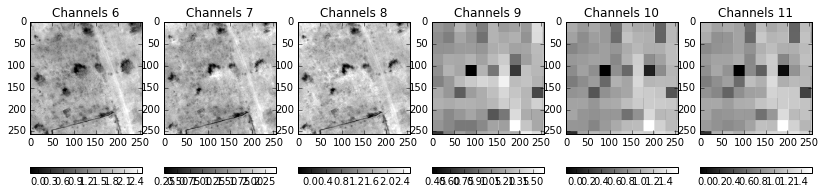

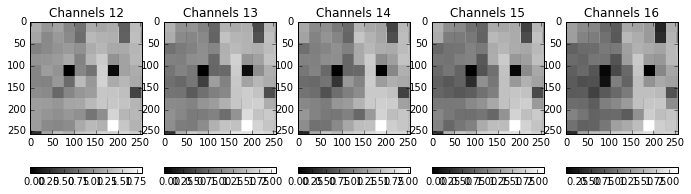

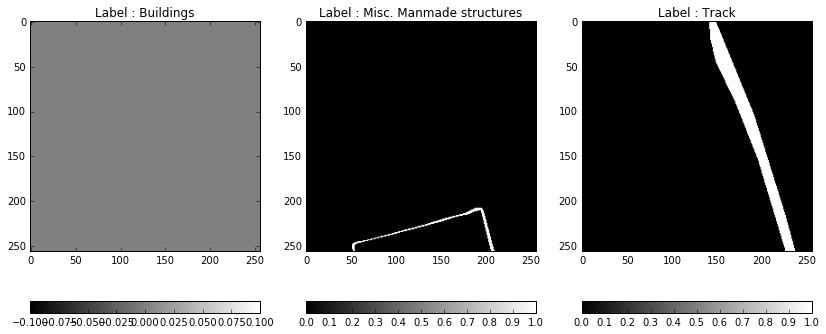

In [21]:
batch_size = 5
for X, Y in generate_images(train_files, batch_size):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    for i in range(batch_size):
        
        n, m = 3, int(n_channels * 1.0 / 3.0 + 0.5)
        for j in range(n_channels):
            if j % m == 0:
                plt.figure(figsize=(14, 4))                
            plt.subplot(1,m,j % m +1)
            display_img_1b(X[i,j,:,:])
            plt.title("Channels %i" % j)
                
        plt.figure(figsize=(14, 6))    
        if n_labels < 8:
            n, m = 1, n_labels
        else:
            n, m = 3, int(n_labels * 1.0 / 3.0 + 0.5), 
        for j in range(n_labels):
            plt.subplot(n, m,j+1)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label : %s" % LABELS[labels[j]])

    break

In [22]:
import os
from keras.optimizers import Adam, Nadam, SGD, Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from metrics import jaccard_coef, jaccard_coef_int

## Test unet_two

In [23]:
deep=False
n_filters_0=32

model = unet_two(n_labels, n_channels, *tile_size, deep=deep, n_filters_0=n_filters_0)

weights_filename = os.path.join("weights", "unet_two_%i_%i_%s_%i.h5" % (n_channels, n_labels, str(deep), n_filters_0))
# if os.path.exists(weights_filename):
#     print "Found weights file %s" % weights_filename
#     model.load_weights(weights_filename)

In [24]:
channels, labels, np.array(LABELS)[labels]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([1, 2, 4]),
 array(['Buildings', 'Misc. Manmade structures', 'Track'], 
       dtype='|S24'))

In [25]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 17, 256, 256)  0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 16, 256, 256)  2464        input_1[0][0]                    
____________________________________________________________________________________________________
inverse_1 (Inverse)              (None, 16, 256, 256)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
inverse_2 (Inverse)              (None, 16, 256, 256)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [26]:
if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint(weights_filename, monitor='loss', save_best_only=True)
# earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)

In [30]:
# model.compile(optimizer=Nadam(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
# model.compile(optimizer=Nadam(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

# model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
# model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

model.compile(optimizer=Adadelta(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'recall', 'precision'])

We have 25 images splitted into 64 tiles. It gives 1600 tiles to train on.
Train/test split with test size 0.3 gives: 1120 and 480 number of tiles.
Assembling 32 tiles in a batch, we obtain 35 batches for training tiles and 15 batches for validation.

In [31]:
# from keras.callbacks import RemoteMonitor
# rmon = RemoteMonitor(root='http://localhost:9000', path='/publish/epoch/end/', field='data', headers={'Content-Type': 'application/json', 'Accept': 'application/json'})

In [33]:
# foo = lambda x: max(x // 10, min(batch_size * 10, x))

batch_size = 8
samples_per_epoch = 64
nb_val_samples = 16


print batch_size, samples_per_epoch, nb_val_samples

history = model.fit_generator(
    generate_images(train_files, batch_size),
    samples_per_epoch=samples_per_epoch, 
    nb_epoch=10,
    validation_data=generate_images(val_files, batch_size),
    nb_val_samples=nb_val_samples,
    callbacks=[model_checkpoint],
    verbose=2
)

8 64 16
Epoch 1/10
152s - loss: 16.5620 - jaccard_coef: 1.4524e-05 - jaccard_coef_int: 5.2630e-15 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 16.7026 - val_jaccard_coef: 1.5092e-05 - val_jaccard_coef_int: 3.5689e-17 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
146s - loss: 16.4598 - jaccard_coef: 1.5138e-05 - jaccard_coef_int: 5.4663e-17 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 16.7769 - val_jaccard_coef: 1.5476e-05 - val_jaccard_coef_int: 4.1095e-17 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
145s - loss: 16.3634 - jaccard_coef: 1.5109e-05 - jaccard_coef_int: 7.4819e-17 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 16.3765 - val_jaccard_coef: 1.4947e-05 - val_jaccard_coef_int: 9.7888e-17 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
150s - loss: 16.5172 - jaccard_coef: 1.5113e-05 - jaccard_coef_int: 5.3484e-17 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 16.3421 - val_jaccard_c

KeyboardInterrupt: 

In [107]:
# model.save_weights(weights_filename)

If `nan` appears, analyse a step by step

In [21]:
# batch_size = 10
# for X, Y in generate_images(train_files, batch_size):
#     print X.shape, Y.shape
#     print X.min(), X.max(), Y.min(), Y.max()

#     hist = model.fit(X, Y, batch_size=batch_size//2, nb_epoch=5, verbose=2)
#     Y_pred = model.predict(X, batch_size=batch_size//2)
#     print Y_pred.min(), Y_pred.max()
#     break

Tile id: 6110_3_1_0_384.tif
Tile id: 6100_2_2_1728_384.tif
Tile id: 6100_2_2_832_1728.tif
Tile id: 6110_1_2_3072_1728.tif
Tile id: 6010_4_4_384_3072.tif
Tile id: 6040_1_0_384_1280.tif
Tile id: 6040_2_2_2624_1728.tif
Tile id: 6040_2_2_384_384.tif
Tile id: 6040_2_2_832_0.tif
Tile id: 6100_2_2_2176_2624.tif
(10L, 5L, 256L, 256L) (10L, 4L, 256L, 256L)
-0.0502791 0.190906 0.0 1.0
Epoch 1/5


MemoryError: Error allocating 20971520 bytes of device memory (CNMEM_STATUS_OUT_OF_MEMORY).
Apply node that caused the error: GpuAllocEmpty(Assert{msg='The convolution would produce an invalid shape (dim[0] < 0).'}.0, Assert{msg='The convolution would produce an invalid shape (dim[1] < 0).'}.0, Assert{msg='The convolution would produce an invalid shape (dim[2] <= 0).'}.0, Assert{msg='The convolution would produce an invalid shape (dim[3] <= 0).'}.0)
Toposort index: 1252
Inputs types: [TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar)]
Inputs shapes: [(), (), (), ()]
Inputs strides: [(), (), (), ()]
Inputs values: [array(5L, dtype=int64), array(16L, dtype=int64), array(256L, dtype=int64), array(256L, dtype=int64)]
Outputs clients: [[GpuDnnConv{algo='small', inplace=True}(GpuContiguous.0, GpuContiguous.0, GpuAllocEmpty.0, GpuDnnConvDesc{border_mode='half', subsample=(1, 1), conv_mode='conv', precision='float32'}.0, Constant{1.0}, Constant{0.0})]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [23]:
# layer = model.get_layer(index=2)
# print layer.weights
# print layer.W.eval()[0,0,:,:]

# layer = model.get_layer(index=1)
# print layer.weights
# print layer.W.eval()[0,0,:,:]
# layer = model.get_layer(index=5)
# print layer.weights
# print layer.W.eval()[0,0,:,:]

[convolution2d_4_W, convolution2d_4_b]
[[ 0.20707504  0.11569368 -0.26223308]
 [-0.037168    0.14761208  0.18767962]
 [-0.03102852 -0.20170985 -0.04872162]]
[convolution2d_3_W, convolution2d_3_b]
[[ 0.22671278  0.2578637   0.17819569]
 [-0.00840357  0.07493455 -0.24825001]
 [ 0.14824052  0.03659624 -0.11134839]]
[convolution2d_5_W, convolution2d_5_b]
[[ 0.46003461]]


Test 'categorical_crossentropy' vs 'binary_crossentropy'

In [38]:
# from keras import backend as K

# batch_size = 2
# for X, Y in generate_images(train_files, batch_size):
#     print X.shape, Y.shape
#     print X.min(), X.max(), Y.min(), Y.max()

# #     hist = model.fit(X, Y, batch_size=batch_size//2, nb_epoch=5, verbose=2)
#     Y_pred = model.predict(X, batch_size=batch_size//2)
    
#     cce = K.categorical_crossentropy(Y_pred, Y)
#     bce = K.binary_crossentropy(Y_pred, Y)
    
#     print cce.eval(), bce.eval()
#     break

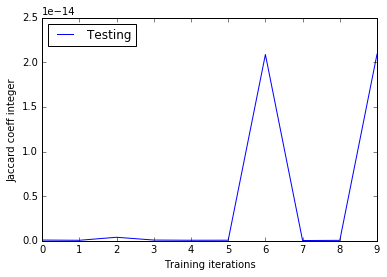

In [129]:
plt.plot(history.history['val_jaccard_coef_int'])
plt.ylabel('Jaccard coeff integer')
# plt.plot(history.history['val_jaccard_coef'])
# plt.ylabel('Jaccard coeff')
# plt.plot(history.history['loss'])
# plt.ylabel('loss')
plt.xlabel('Training iterations')
plt.legend(['Testing'], loc='upper left')
plt.show()

In [125]:
def _plot(X, Y, Y_pred, i, c=1):
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    display_img_1b(X[i,0,:,:])
    plt.subplot(132)
    display_img_1b(Y[i,c,:,:])
    plt.subplot(133)
    display_img_1b(Y_pred[i,c,:,:])

(5, 3, 256, 256) 3.35437e-06 8.4444e-05


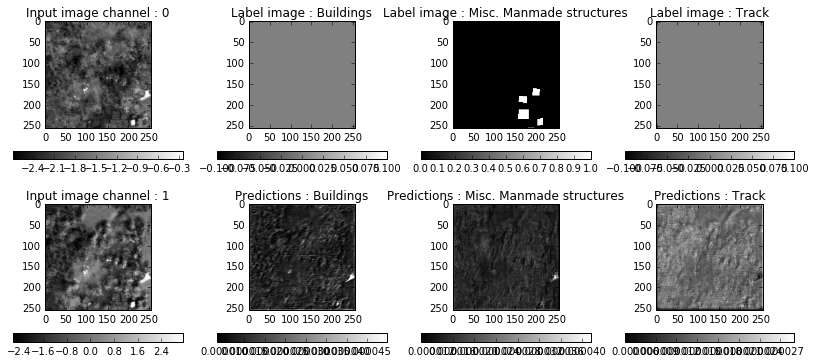

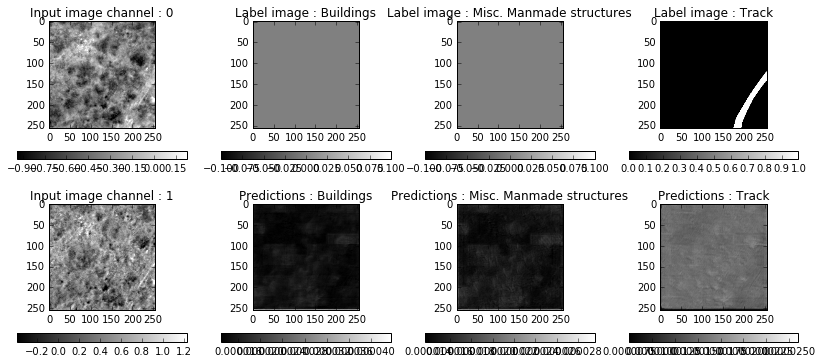

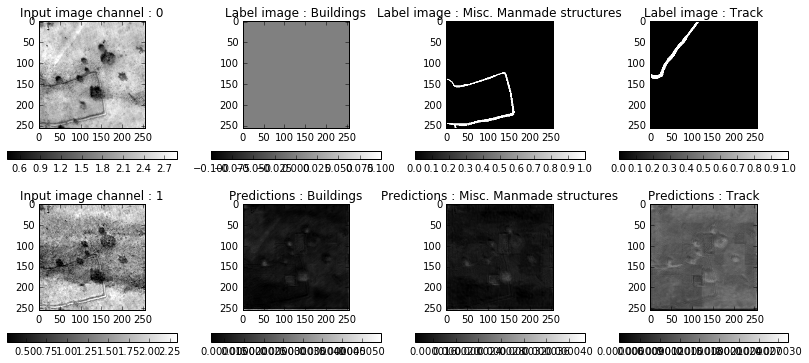

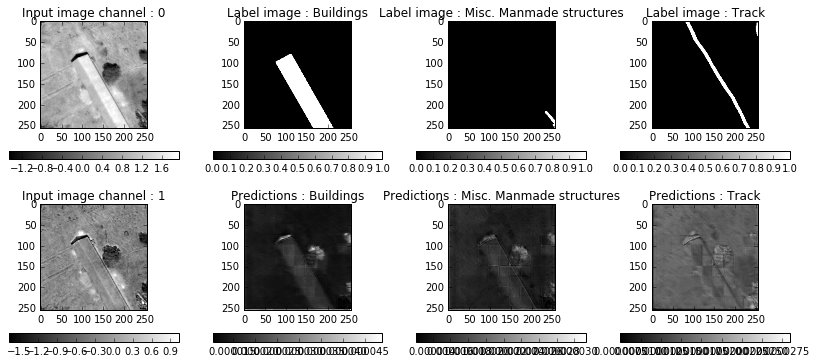

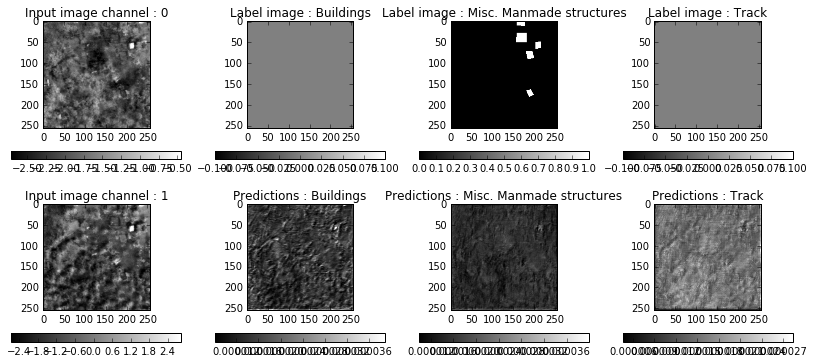

In [34]:
batch_size = 5

for X, Y in generate_images(train_files, batch_size):
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()

#     for i in range(batch_size):
#         _plot(X, Y, Y_pred, i)
#     print jaccard_coef(Y, Y_pred), jaccard_coef_int(Y, Y_pred)

    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(2,n_labels+1,1)
        display_img_1b(X[i,0,:,:])
        plt.title("Input image channel : %i" % 0)
        for j in range(n_labels):
            plt.subplot(2,n_labels+1,j+2)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label image : %s" % LABELS[labels[j]])
        
        plt.subplot(2,n_labels+1,j+3)
        display_img_1b(X[i,1,:,:])   
        plt.title("Input image channel : %i" % 1)
        for jj in range(n_labels):
            plt.subplot(2,n_labels+1,jj+j+4)
            display_img_1b(Y_pred[i,jj,:,:])
            plt.title("Predictions : %s" % LABELS[labels[jj]])

    break


## Test unet_ratios

In [134]:
deep=False 
n_filters_0=32

model = unet_ratios(n_labels, n_channels, *tile_size, deep=deep, n_filters_0=n_filters_0)

weights_filename = os.path.join("weights", "unet_two_%i_%i_%s_%i.h5" % (n_channels, n_labels, str(deep), n_filters_0))
# if os.path.exists(weights_filename):
#     print "Found weights file %s" % weights_filename
#     model.load_weights(weights_filename)

In [135]:
channels, labels, np.array(LABELS)[labels]

(array([0, 1, 2, 3, 4]),
 array([1, 2, 4]),
 array(['Buildings', 'Misc. Manmade structures', 'Track'], 
       dtype='|S24'))

In [136]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 5, 256, 256)   0                                            
____________________________________________________________________________________________________
inverse_10 (Inverse)             (None, 5, 256, 256)   0           input_6[0][0]                    
____________________________________________________________________________________________________
convolution2d_142 (Convolution2D (None, 32, 256, 256)  1472        input_6[0][0]                    
____________________________________________________________________________________________________
convolution2d_143 (Convolution2D (None, 32, 256, 256)  1472        inverse_10[0][0]                 
___________________________________________________________________________________________

In [137]:
if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint(weights_filename, monitor='loss', save_best_only=True)
# earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)

In [138]:
model.compile(optimizer=Adadelta(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'recall', 'precision'])

We have 25 images splitted into 64 tiles. It gives 1600 tiles to train on.
Train/test split with test size 0.3 gives: 1120 and 480 number of tiles.
Assembling 32 tiles in a batch, we obtain 35 batches for training tiles and 15 batches for validation.

In [139]:
# foo = lambda x: max(x // 10, min(batch_size * 10, x))

batch_size = 8
samples_per_epoch = 64
nb_val_samples = 16


print batch_size, samples_per_epoch, nb_val_samples

history = model.fit_generator(
    generate_images(train_files, batch_size),
    samples_per_epoch=samples_per_epoch, 
    nb_epoch=100,
    validation_data=generate_images(val_files, batch_size),
    nb_val_samples=nb_val_samples,
    callbacks=[model_checkpoint],
    verbose=2
)

8 64 16
Epoch 1/100
106s - loss: 103.3669 - jaccard_coef: 1.5316e-05 - jaccard_coef_int: 4.5135e-17 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 140.7129 - val_jaccard_coef: 1.5285e-05 - val_jaccard_coef_int: 3.4142e-17 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/100
98s - loss: 99.3262 - jaccard_coef: 1.5278e-05 - jaccard_coef_int: 3.7204e-17 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 108.2455 - val_jaccard_coef: 1.5068e-05 - val_jaccard_coef_int: 4.6624e-17 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/100
96s - loss: 102.5495 - jaccard_coef: 1.5123e-05 - jaccard_coef_int: 3.4686e-17 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 66.3659 - val_jaccard_coef: 1.2622e-05 - val_jaccard_coef_int: 2.0903e-14 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/100
95s - loss: 126.7798 - jaccard_coef: 1.5242e-05 - jaccard_coef_int: 2.9461e-17 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 74.9729 - val_jac

In [107]:
# model.save_weights(weights_filename)

If `nan` appears, analyse a step by step

In [21]:
# batch_size = 10
# for X, Y in generate_images(train_files, batch_size):
#     print X.shape, Y.shape
#     print X.min(), X.max(), Y.min(), Y.max()

#     hist = model.fit(X, Y, batch_size=batch_size//2, nb_epoch=5, verbose=2)
#     Y_pred = model.predict(X, batch_size=batch_size//2)
#     print Y_pred.min(), Y_pred.max()
#     break

Tile id: 6110_3_1_0_384.tif
Tile id: 6100_2_2_1728_384.tif
Tile id: 6100_2_2_832_1728.tif
Tile id: 6110_1_2_3072_1728.tif
Tile id: 6010_4_4_384_3072.tif
Tile id: 6040_1_0_384_1280.tif
Tile id: 6040_2_2_2624_1728.tif
Tile id: 6040_2_2_384_384.tif
Tile id: 6040_2_2_832_0.tif
Tile id: 6100_2_2_2176_2624.tif
(10L, 5L, 256L, 256L) (10L, 4L, 256L, 256L)
-0.0502791 0.190906 0.0 1.0
Epoch 1/5


MemoryError: Error allocating 20971520 bytes of device memory (CNMEM_STATUS_OUT_OF_MEMORY).
Apply node that caused the error: GpuAllocEmpty(Assert{msg='The convolution would produce an invalid shape (dim[0] < 0).'}.0, Assert{msg='The convolution would produce an invalid shape (dim[1] < 0).'}.0, Assert{msg='The convolution would produce an invalid shape (dim[2] <= 0).'}.0, Assert{msg='The convolution would produce an invalid shape (dim[3] <= 0).'}.0)
Toposort index: 1252
Inputs types: [TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar)]
Inputs shapes: [(), (), (), ()]
Inputs strides: [(), (), (), ()]
Inputs values: [array(5L, dtype=int64), array(16L, dtype=int64), array(256L, dtype=int64), array(256L, dtype=int64)]
Outputs clients: [[GpuDnnConv{algo='small', inplace=True}(GpuContiguous.0, GpuContiguous.0, GpuAllocEmpty.0, GpuDnnConvDesc{border_mode='half', subsample=(1, 1), conv_mode='conv', precision='float32'}.0, Constant{1.0}, Constant{0.0})]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [23]:
# layer = model.get_layer(index=2)
# print layer.weights
# print layer.W.eval()[0,0,:,:]

# layer = model.get_layer(index=1)
# print layer.weights
# print layer.W.eval()[0,0,:,:]
# layer = model.get_layer(index=5)
# print layer.weights
# print layer.W.eval()[0,0,:,:]

[convolution2d_4_W, convolution2d_4_b]
[[ 0.20707504  0.11569368 -0.26223308]
 [-0.037168    0.14761208  0.18767962]
 [-0.03102852 -0.20170985 -0.04872162]]
[convolution2d_3_W, convolution2d_3_b]
[[ 0.22671278  0.2578637   0.17819569]
 [-0.00840357  0.07493455 -0.24825001]
 [ 0.14824052  0.03659624 -0.11134839]]
[convolution2d_5_W, convolution2d_5_b]
[[ 0.46003461]]


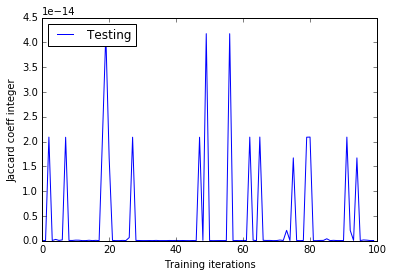

In [140]:
plt.plot(history.history['val_jaccard_coef_int'])
plt.ylabel('Jaccard coeff integer')
# plt.plot(history.history['val_jaccard_coef'])
# plt.ylabel('Jaccard coeff')
# plt.plot(history.history['loss'])
# plt.ylabel('loss')
plt.xlabel('Training iterations')
plt.legend(['Testing'], loc='upper left')
plt.show()

In [125]:
def _plot(X, Y, Y_pred, i, c=1):
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    display_img_1b(X[i,0,:,:])
    plt.subplot(132)
    display_img_1b(Y[i,c,:,:])
    plt.subplot(133)
    display_img_1b(Y_pred[i,c,:,:])

(5, 3, 256, 256) 1.9005e-06 5.46535e-05


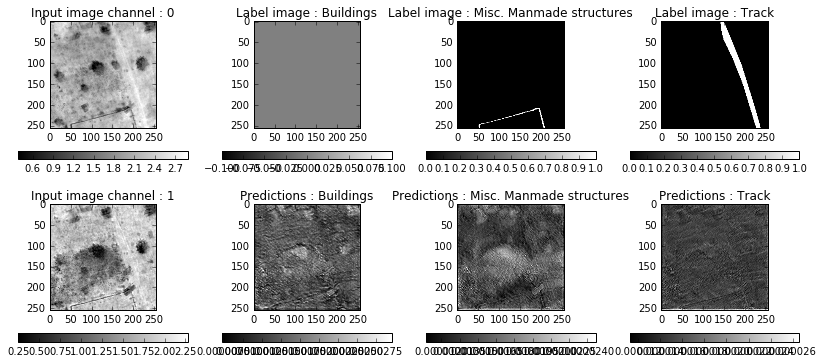

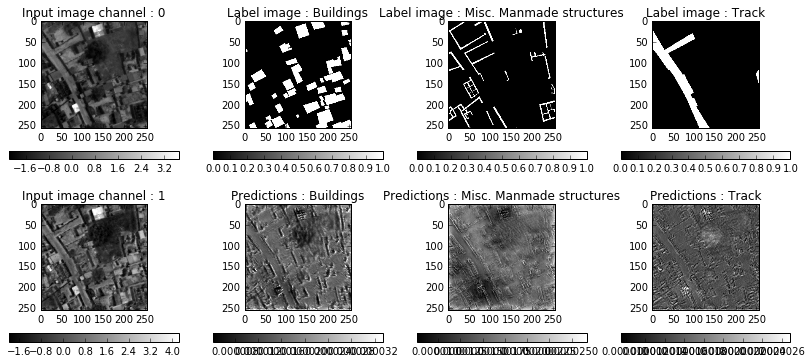

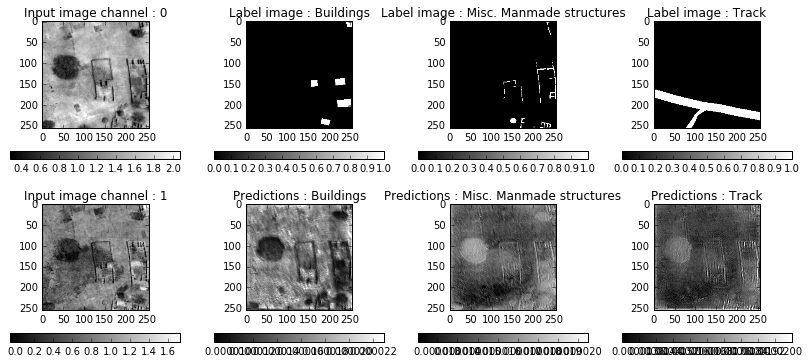

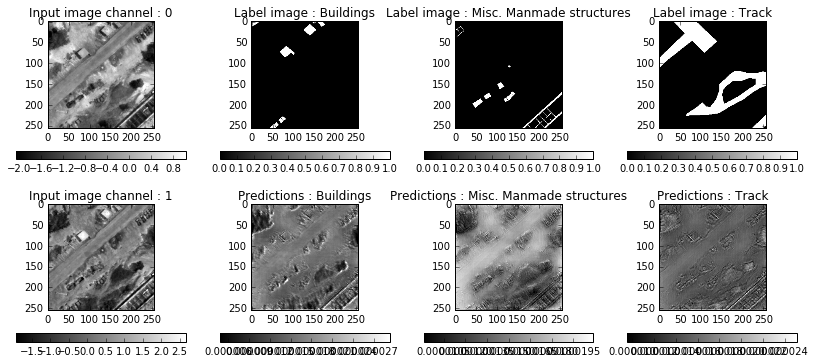

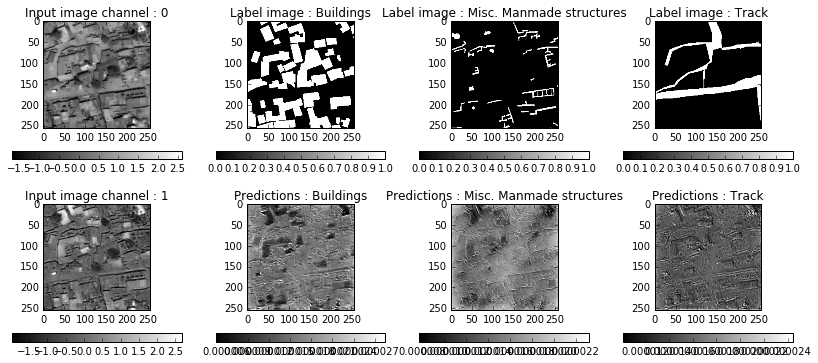

In [141]:
batch_size = 5

for X, Y in generate_images(train_files, batch_size):
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()

#     for i in range(batch_size):
#         _plot(X, Y, Y_pred, i)
#     print jaccard_coef(Y, Y_pred), jaccard_coef_int(Y, Y_pred)

    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(2,n_labels+1,1)
        display_img_1b(X[i,0,:,:])
        plt.title("Input image channel : %i" % 0)
        for j in range(n_labels):
            plt.subplot(2,n_labels+1,j+2)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label image : %s" % LABELS[labels[j]])
        
        plt.subplot(2,n_labels+1,j+3)
        display_img_1b(X[i,1,:,:])   
        plt.title("Input image channel : %i" % 1)
        for jj in range(n_labels):
            plt.subplot(2,n_labels+1,jj+j+4)
            display_img_1b(Y_pred[i,jj,:,:])
            plt.title("Predictions : %s" % LABELS[labels[jj]])

    break
